In [184]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [128]:
client = bigquery.Client()

query="""
SELECT DATE2 AS DATE, theme AS THEME, AVG_TONE, AVG_POSITIVE_SCORE, AVG_NEGATIVE_SCORE, AVG_POLARITY
from goldenfleece.sentiment.econ_sentiment
"""
tone_df = client.query(query).to_dataframe()
tone_df.head()

,DATE,THEME,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY
0,20200101,ECON_STOCKMARKET,-1.567346011,2.562600370,4.129946382,6.692546752
1,20200101,PROTEST,-3.830024030,2.596364143,6.426388172,9.022752314
2,20200101,EPU_POLICY_GOVERNMENT,-2.564577567,2.516411547,5.080989114,7.597400661
3,20200101,WB_450_DEBT,-2.387775981,2.277089696,4.664865677,6.941955373
4,20200101,EPU_POLICY_BUDGET,-0.228560313,2.734856654,2.963416967,5.698273621


<IPython.core.display.Javascript object>

In [129]:
tone_df = tone_df.astype({"DATE":"datetime64", "THEME":"category","AVG_TONE":float, "AVG_POSITIVE_SCORE":float, "AVG_NEGATIVE_SCORE":float, "AVG_POLARITY":float}).set_index("DATE")
tone_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3621 entries, 2020-01-01 to 2020-11-25
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   THEME               3621 non-null   category
 1   AVG_TONE            3621 non-null   float64 
 2   AVG_POSITIVE_SCORE  3621 non-null   float64 
 3   AVG_NEGATIVE_SCORE  3621 non-null   float64 
 4   AVG_POLARITY        3621 non-null   float64 
dtypes: category(1), float64(4)
memory usage: 145.4 KB


<IPython.core.display.Javascript object>

In [144]:
tone_df.THEME.value_counts()

WB_450_DEBT                 330
UNEMPLOYMENT                330
PROTEST                     330
HEALTH_VACCINATION          330
EPU_POLICY_GOVERNMENT       330
EPU_ECONOMY                 330
ECON_STOCKMARKET            330
ECON_DEBT                   330
EPU_POLICY_BUDGET           329
ECON_TAXATION               329
TAX_DISEASE_CORONAVIRUS     323
Name: THEME, dtype: int64

<IPython.core.display.Javascript object>

In [161]:
def calculate_first_diff(df):
    df = df.sort_index()
    return df[["AVG_TONE", "AVG_POSITIVE_SCORE", "AVG_NEGATIVE_SCORE"]].diff().dropna()
     
tone_diff = tone_df.groupby("THEME").apply(calculate_first_diff).reset_index(level="THEME")
tone_diff

,THEME,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE
DATE,,,,
2020-01-02,ECON_DEBT,-0.474363,-0.215329,0.259034
2020-01-03,ECON_DEBT,2.089132,1.411457,-0.677675
2020-01-04,ECON_DEBT,-0.313883,-0.792638,-0.478755
2020-01-05,ECON_DEBT,-2.032075,-0.141827,1.890248
2020-01-06,ECON_DEBT,1.611613,0.292123,-1.319489
...,...,...,...,...
2020-11-21,WB_450_DEBT,1.096042,0.552476,-0.543566
2020-11-22,WB_450_DEBT,-0.555935,-0.206503,0.349432
2020-11-23,WB_450_DEBT,-0.137304,-0.116364,0.020940


<IPython.core.display.Javascript object>

In [48]:
query="""
SELECT * from goldenfleece.sentiment.ftse100 order by Date
"""
ftse_df = client.query(query).to_dataframe()
ftse_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2019-09-20,7356.399902,7376.299805,7322.000000,7344.899902,7344.899902,1656288000
1,2019-09-23,7344.899902,7362.299805,7284.799805,7326.100098,7326.100098,489660300
2,2019-09-24,7326.100098,7349.000000,7281.899902,7291.399902,7291.399902,588772200
3,2019-09-25,7291.399902,7292.000000,7213.000000,7290.000000,7290.000000,704553100
4,2019-09-26,7290.000000,7387.100098,7277.200195,7351.100098,7351.100098,704707500


In [49]:
ftse_df = ftse_df.astype({"Date":"datetime64"}).set_index("Date") 
ftse_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2019-09-20 to 2020-11-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       300 non-null    float64
 1   High       300 non-null    float64
 2   Low        300 non-null    float64
 3   Close      300 non-null    float64
 4   Adj_Close  300 non-null    float64
 5   Volume     300 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 16.4 KB


In [72]:
adj_close = ftse_df.sort_index()["Adj_Close"]
adj_close_diff = adj_close.diff()

<AxesSubplot:xlabel='Date'>

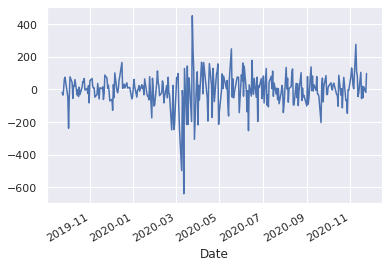

In [98]:
adj_close_diff.plot()

In [162]:
merged_df = tone_diff.merge(adj_close_diff, left_index=True, right_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2020-01-02 to 2020-11-24
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   THEME               2515 non-null   category
 1   AVG_TONE            2515 non-null   float64 
 2   AVG_POSITIVE_SCORE  2515 non-null   float64 
 3   AVG_NEGATIVE_SCORE  2515 non-null   float64 
 4   Adj_Close           2515 non-null   float64 
dtypes: category(1), float64(4)
memory usage: 101.1 KB


<IPython.core.display.Javascript object>

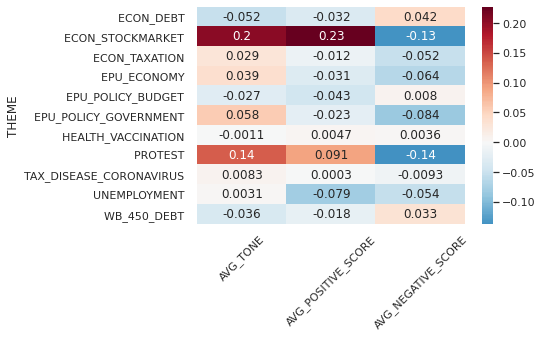

<IPython.core.display.Javascript object>

In [186]:
corr_df = merged_df.groupby("THEME").corr(method="pearson")["Adj_Close"].drop(index="Adj_Close", level=1).unstack()

ax = sns.heatmap(corr_df, cmap='RdBu_r', center=0, annot=True)
plt.xticks(rotation=45);

#### Take the first difference of each time series and plot scatterplots

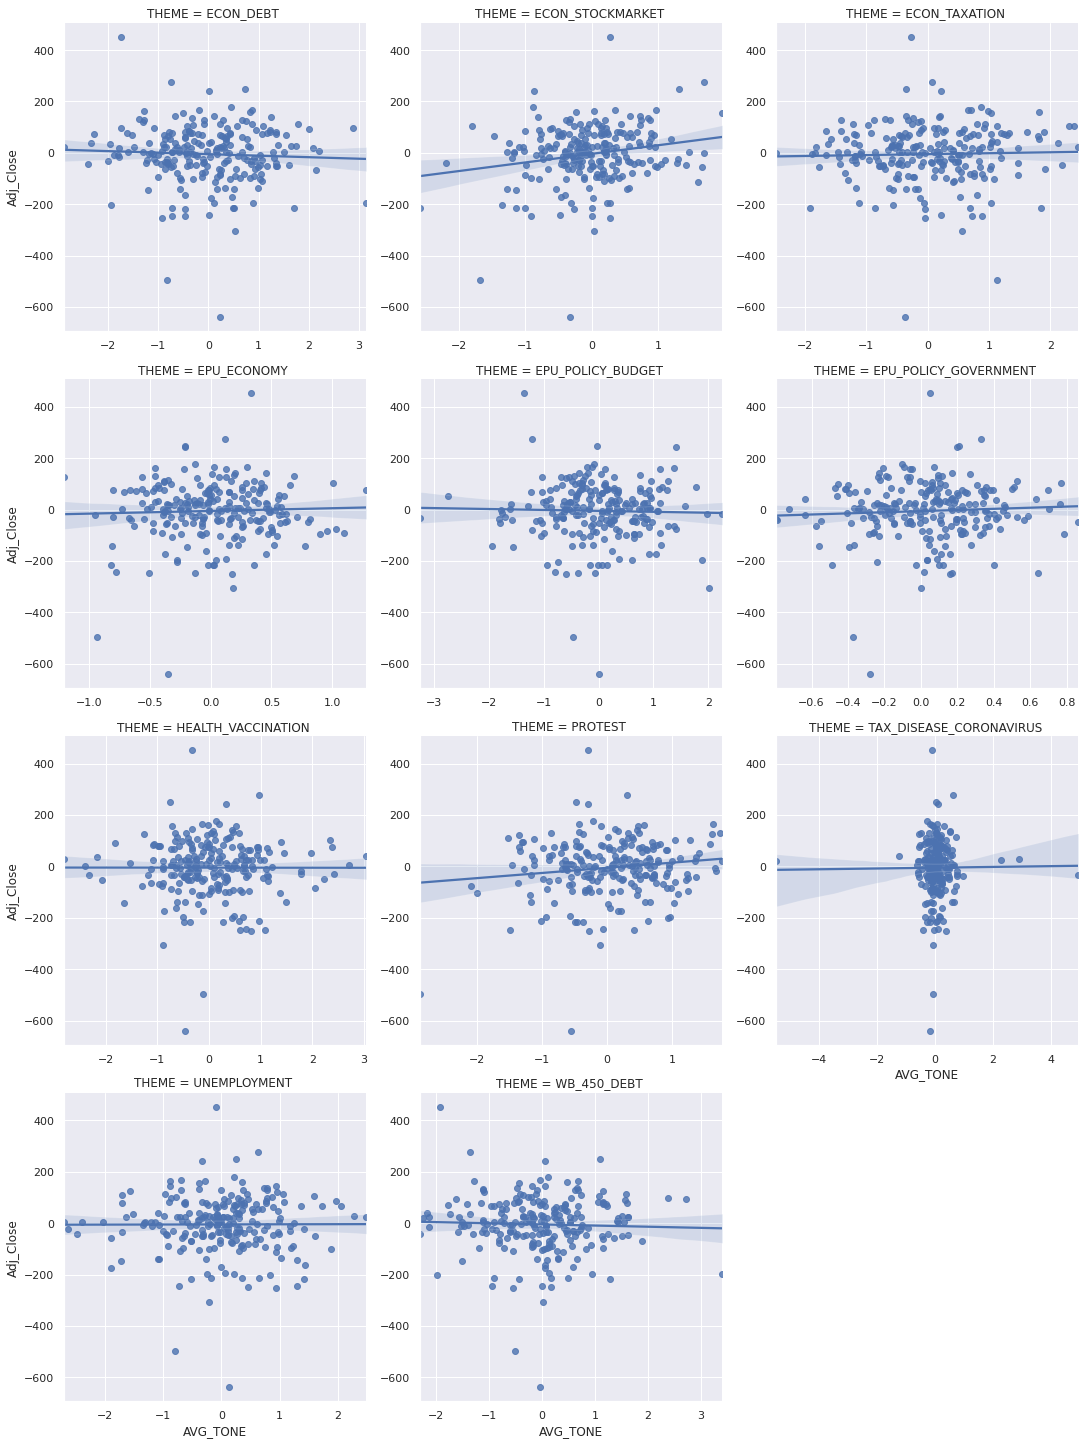

<IPython.core.display.Javascript object>

In [192]:
sns.lmplot(x="AVG_TONE", y="Adj_Close", data=merged_df, col="THEME", col_wrap=3, sharex=False, sharey=False)

In [112]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

tone_cross_correlation = {lag:crosscorr(merged_df["AVG_TONE"], merged_df["Adj_Close"], lag) for lag in range(-10, 10)}

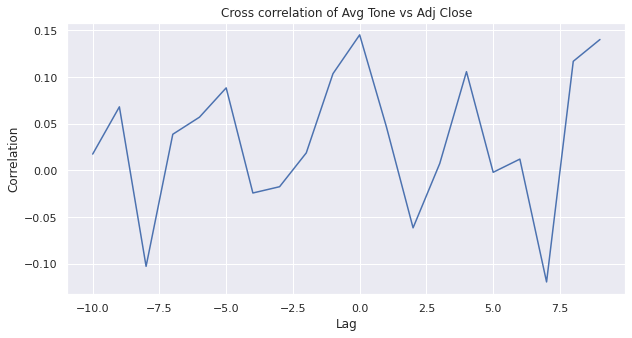

In [113]:
ax = pd.Series(tone_cross_correlation).plot(figsize=(10,5))
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation")
ax.set_title("Cross correlation of Avg Tone vs Adj Close");